<a href="https://colab.research.google.com/github/dgiri4132/adaptivegarchmodel/blob/main/adaptivegarchmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install arch


In [13]:
import yfinance as yf
import pandas as pd
tickers=[t.upper() for t in input('Enter Stocks tickers(separated by space like aapl msft tsla):').split()]
start_date=input('Enter the start date in yyyy-mm-dd format:')
end_date=input('Enter the end date in yyyy-mm-dd format:')
forecast_horizon=int(input('Enter number of days ahead that you want the projection: '))
price_data=yf.download(tickers,start_date,end_date,auto_adjust=False)['Adj Close']
price_data.dropna(axis=1, how='all', inplace=True)
return_data=price_data.pct_change().dropna()
tickers = price_data.columns.tolist()

Enter Stocks tickers(separated by space like aapl msft tsla):axp amzn nvda
Enter the start date in yyyy-mm-dd format:2024-01-01
Enter the end date in yyyy-mm-dd format:2025-01-01
Enter number of days ahead that you want the projection: 15


[*********************100%***********************]  3 of 3 completed


Enter the rolling window size(has to be at most the size of the data period):150
Backtest Results: 
Annualized Sharpe Ratio: 1.219143
Average Turnover: 0.030588


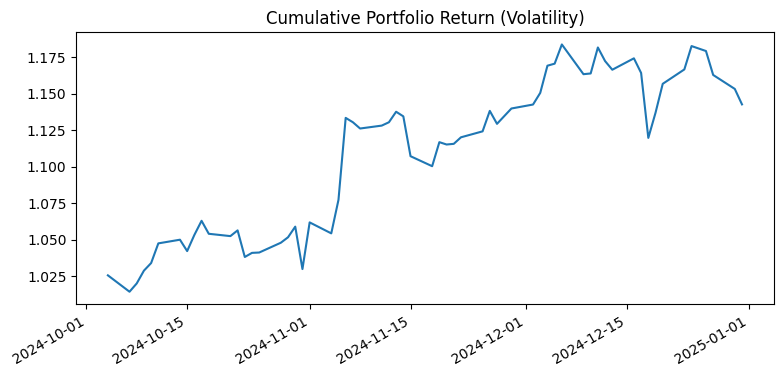

In [30]:
#Analyzing residuals for best model to use
from arch import arch_model
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
split_idx=int(len(return_data)*0.7)
train_data=return_data.iloc[:split_idx]
test_data=return_data.iloc[split_idx:]
def residual_analyze(return_series):
  model=arch_model(return_series,vol='GARCH',p=1,q=1,dist='normal')
  result=model.fit(disp='off')
  resid=result.resid
  cond_vol=result.conditional_volatility
  std_resid=resid/cond_vol
  s=skew(std_resid)
  k=kurtosis(std_resid,fisher=True)
  return s, k, result
rolling_window=int(input('Enter the rolling window size(has to be at most the size of the data period):'))
rolling_weights=[]
rolling_dates=[]
rolling_returns=[]
prev_weights=None
turnovers=[]
vol_forecast_log=[]
for i in range(split_idx,len(return_data)-forecast_horizon):
  window_data=return_data.iloc[i-rolling_window:i]
  vol_today={}
  for ticker in tickers:
    series=window_data[ticker]
    s,k,_=residual_analyze(series)
    if abs(s)>0.5 and k>3:
      model=arch_model(series,vol='EGARCH',p=1,o=1,q=1,dist='skewt')
    elif abs(s)>0.5:
      model=arch_model(series,vol='EGARCH',p=1,o=1,q=1,dist='normal')
    elif k>3:
      model=arch_model(series,vol='GARCH',p=1,q=1,dist='t')
    else:
      model=arch_model(series,vol='GARCH',p=1,q=1,dist='normal')
    try:
      result=model.fit(disp='off', options={'maxiter':2000})
      forecast=result.forecast(horizon=forecast_horizon)
      variance_series = forecast.variance.iloc[-1,:forecast_horizon].mean()
      vol_today[ticker] = np.sqrt(variance_series)

    except Exception as e:
      print(f'{ticker} failed to fit at index {i}, skipping it.')
      vol_today[ticker]=np.nan
  vol_series=pd.Series(vol_today).dropna()
  vol_forecast_log.append((return_data.index[i+forecast_horizon],vol_series))
  if vol_series.empty:
    continue
  inv_vol=1/vol_series
  weights=inv_vol/inv_vol.sum()
  weights=weights.reindex(tickers).fillna(0)
  if weights[weights>0].count()<2:
    continue
  if prev_weights is not None:
    turnover=np.sum(np.abs(weights-prev_weights))
    turnovers.append(turnover)
  prev_weights=weights
  try:
    future_return=return_data.iloc[i+forecast_horizon][tickers]
    daily_returns=(future_return*weights).sum()/100
    rolling_weights.append(weights)
    rolling_dates.append(return_data.index[i+forecast_horizon])
    rolling_returns.append(daily_returns)
  except:
    continue
portfolio_returns=pd.Series(rolling_returns,index=rolling_dates)
cumulative_returns=(1+portfolio_returns).cumprod()
rf_daily=0.03/252
excess_return=portfolio_returns-rf_daily
trading_days=portfolio_returns.count()
sharpe_ratio=excess_return.mean()/excess_return.std()*np.sqrt(trading_days)
avg_turnover=np.mean(turnovers)

print('Backtest Results: ')
print(f'Annualized Sharpe Ratio: {sharpe_ratio:2f}')
print(f'Average Turnover: {avg_turnover:2f}')
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
cumulative_returns.plot(title='Cumulative Portfolio Return (Volatility)')
plt.show()
